In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Parte 1

          day entity product    price_tier anticipation_method payment_method  \
0  2025-01-01     PJ     pix  intermediary                 Pix     uninformed   
1  2025-01-01     PJ     pos  intermediary      D1Anticipation         credit   
2  2025-01-01     PJ     tap        normal            D0/Nitro         credit   
3  2025-01-01     PJ     tap    domination      D1Anticipation          debit   
4  2025-01-01     PJ     tap    aggressive            D0/Nitro         credit   

   installments  amount_transacted  quantity_transactions  \
0             1          546030.68                  13361   
1             1          574568.13                   9104   
2             1          342178.87                   2655   
3             1            1183.21                     63   
4             1           10158.11                     30   

   quantity_of_merchants  
0                    675  
1                    694  
2                   1607  
3                      9  
4          

C:\Users\lucas\AppData\Local\Temp\ipykernel_8828\1643758685.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['amount_transacted'].sum() / x['quantity_transactions'].sum())


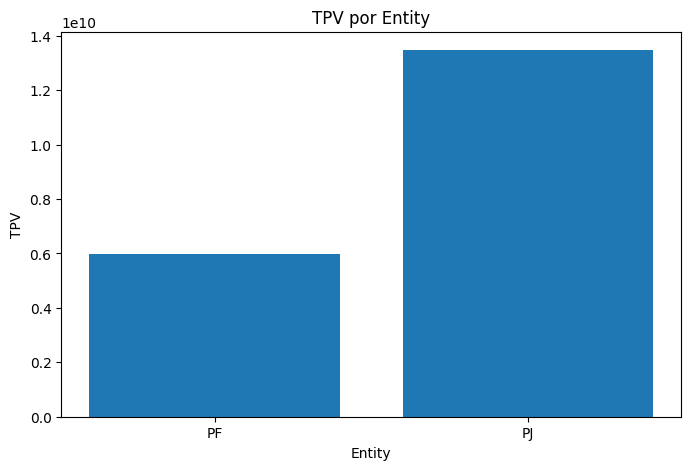

In [2]:
df = pd.read_csv('Operations_analyst_data.csv')

# 3. Explorar dados
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

# 4. Criar KPIs
# TPV = soma do amount_transacted
tpv = df['amount_transacted'].sum()

# Average Ticket = amount_transacted / quantity_transactions
avg_ticket = df['amount_transacted'].sum() / df['quantity_transactions'].sum()

print(f"TPV Total: {tpv:,.2f}")
print(f"Average Ticket: {avg_ticket:,.2f}")

# 5. Análises por dimensão
tpv_by_entity = df.groupby("entity")['amount_transacted'].sum().reset_index()
avg_ticket_by_entity = (df.groupby("entity")
                         .apply(lambda x: x['amount_transacted'].sum() / x['quantity_transactions'].sum())
                         .reset_index(name="avg_ticket"))

print(tpv_by_entity)
print(avg_ticket_by_entity)

# 6. Visualização inicial
plt.figure(figsize=(8,5))
plt.bar(tpv_by_entity['entity'], tpv_by_entity['amount_transacted'])
plt.title("TPV por Entity")
plt.xlabel("Entity")
plt.ylabel("TPV")
plt.show()

## Parte 2

In [3]:
# Garantir que a coluna de data está em formato datetime
df['transaction_date'] = pd.to_datetime(df['day'])

# Ordenar por data
df = df.sort_values(by="transaction_date")

In [4]:
# KPIs diários
daily_kpis = df.groupby('transaction_date').agg(
    TPV=('amount_transacted', 'sum'),
    Transactions=('quantity_transactions', 'sum')
).reset_index()

daily_kpis['Average_Ticket'] = daily_kpis['TPV'] / daily_kpis['Transactions']

print(daily_kpis.head())


  transaction_date           TPV  Transactions  Average_Ticket
0       2025-01-01  5.199076e+07        762039       68.225845
1       2025-01-02  1.564143e+08       1173190      133.323971
2       2025-01-03  1.680329e+08       1377057      122.023235
3       2025-01-04  1.380698e+08       1461058       94.499903
4       2025-01-05  9.129156e+07       1007278       90.631944


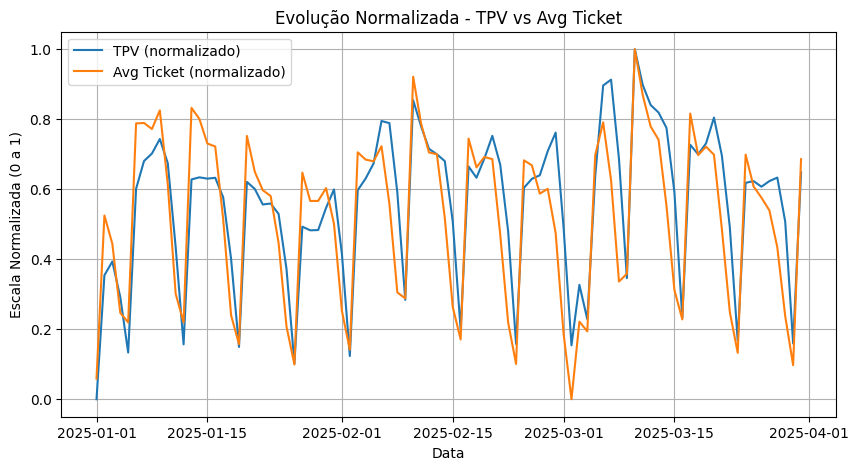

In [5]:
scaler = MinMaxScaler()

daily_scaled = daily_kpis.copy()
daily_scaled[['TPV_norm','AvgTicket_norm']] = scaler.fit_transform(
    daily_kpis[['TPV','Average_Ticket']]
)

plt.figure(figsize=(10,5))
plt.plot(daily_scaled['transaction_date'], daily_scaled['TPV_norm'], label="TPV (normalizado)")
plt.plot(daily_scaled['transaction_date'], daily_scaled['AvgTicket_norm'], label="Avg Ticket (normalizado)")
plt.title("Evolução Normalizada - TPV vs Avg Ticket")
plt.xlabel("Data")
plt.ylabel("Escala Normalizada (0 a 1)")
plt.legend()
plt.grid(True)
plt.show()

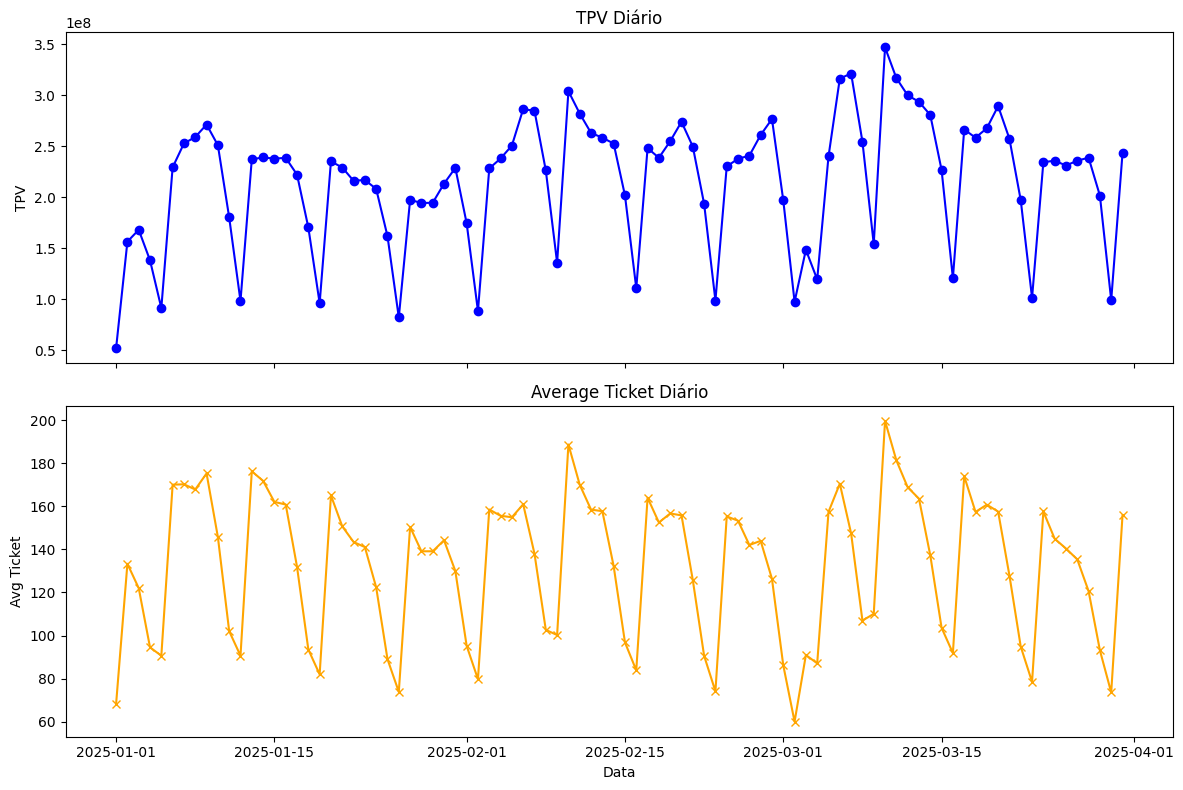

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)

# TPV
ax[0].plot(daily_kpis['transaction_date'], daily_kpis['TPV'], marker='o', color='blue')
ax[0].set_title("TPV Diário")
ax[0].set_ylabel("TPV")

# Avg Ticket
ax[1].plot(daily_kpis['transaction_date'], daily_kpis['Average_Ticket'], marker='x', color='orange')
ax[1].set_title("Average Ticket Diário")
ax[1].set_xlabel("Data")
ax[1].set_ylabel("Avg Ticket")

plt.tight_layout()
plt.show()

In [7]:
daily_kpis['TPV_Pct_Change'] = daily_kpis['TPV'].pct_change()

# Definir threshold
threshold = -0.2  # queda de 20%

# Marcar dias com queda brusca
alerts = daily_kpis[daily_kpis['TPV_Pct_Change'] <= threshold]

if not alerts.empty:
    print("⚠️ ALERTA: Quedas significativas detectadas!")
    print(alerts[['transaction_date', 'TPV', 'TPV_Pct_Change']])
else:
    print("✅ Nenhuma queda significativa detectada.")


⚠️ ALERTA: Quedas significativas detectadas!
   transaction_date           TPV  TPV_Pct_Change
4        2025-01-05  9.129156e+07       -0.338802
10       2025-01-11  1.801449e+08       -0.282160
11       2025-01-12  9.817530e+07       -0.455020
17       2025-01-18  1.702911e+08       -0.233393
18       2025-01-19  9.603292e+07       -0.436066
24       2025-01-25  1.617668e+08       -0.222607
25       2025-01-26  8.209716e+07       -0.492497
31       2025-02-01  1.744327e+08       -0.237438
32       2025-02-02  8.837460e+07       -0.493360
38       2025-02-08  2.262100e+08       -0.205199
39       2025-02-09  1.357104e+08       -0.400069
45       2025-02-15  2.017257e+08       -0.201354
46       2025-02-16  1.107818e+08       -0.450830
52       2025-02-22  1.934902e+08       -0.224830
53       2025-02-23  9.860575e+07       -0.490384
59       2025-03-01  1.968858e+08       -0.288303
60       2025-03-02  9.739636e+07       -0.505315
66       2025-03-08  2.544049e+08       -0.208025
67   

## Parte 3 

In [8]:
# Média móvel de 7 dias
daily_kpis['TPV_MA7'] = daily_kpis['TPV'].rolling(window=7).mean()

# Desvio padrão para identificar anomalias
mean_tpv = daily_kpis['TPV'].mean()
std_tpv = daily_kpis['TPV'].std()

daily_kpis['alerta'] = daily_kpis['TPV'].apply(
    lambda x: 'queda' if x < mean_tpv - 2*std_tpv else (
              'alta' if x > mean_tpv + 2*std_tpv else 'ok')
)

print(daily_kpis[['transaction_date','TPV','alerta']].tail(10))


   transaction_date           TPV alerta
80       2025-03-22  1.970073e+08     ok
81       2025-03-23  1.012779e+08     ok
82       2025-03-24  2.342905e+08     ok
83       2025-03-25  2.357850e+08     ok
84       2025-03-26  2.310399e+08     ok
85       2025-03-27  2.357762e+08     ok
86       2025-03-28  2.387213e+08     ok
87       2025-03-29  2.015402e+08     ok
88       2025-03-30  9.896321e+07     ok
89       2025-03-31  2.431165e+08     ok


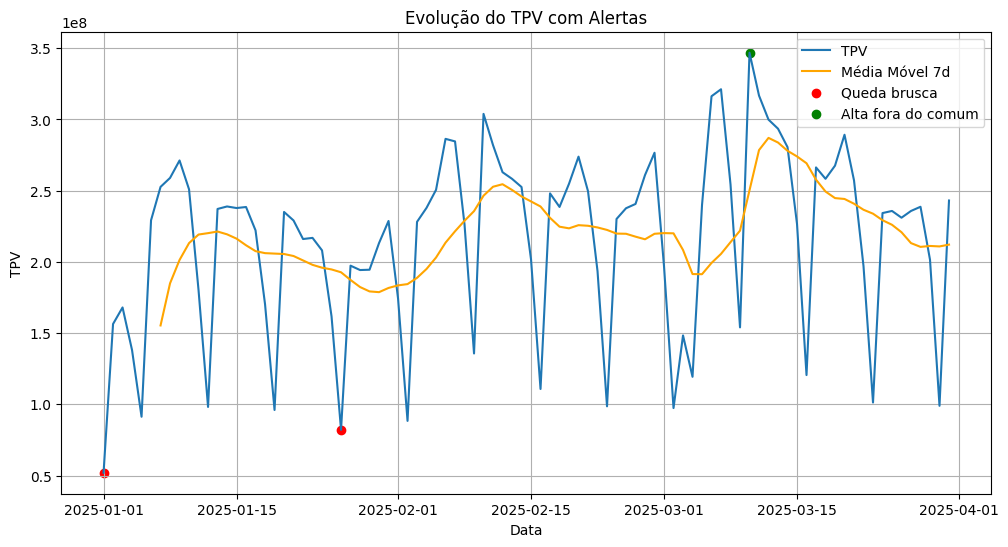

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(daily_kpis['transaction_date'], daily_kpis['TPV'], label="TPV")
plt.plot(daily_kpis['transaction_date'], daily_kpis['TPV_MA7'], label="Média Móvel 7d", color="orange")

# Destacar alertas
queda = daily_kpis[daily_kpis['alerta']=="queda"]
alta = daily_kpis[daily_kpis['alerta']=="alta"]

plt.scatter(queda['transaction_date'], queda['TPV'], color="red", label="Queda brusca")
plt.scatter(alta['transaction_date'], alta['TPV'], color="green", label="Alta fora do comum")

plt.title("Evolução do TPV com Alertas")
plt.xlabel("Data")
plt.ylabel("TPV")
plt.legend()
plt.grid(True)
plt.show()

     weekday          mean           std
0     Friday  2.491692e+08  3.851381e+07
1     Monday  2.421725e+08  4.729564e+07
2   Saturday  1.940481e+08  3.053808e+07
3     Sunday  1.056390e+08  2.017264e+07
4   Thursday  2.546795e+08  4.245616e+07
5    Tuesday  2.367890e+08  4.750599e+07
6  Wednesday  2.313045e+08  5.962412e+07


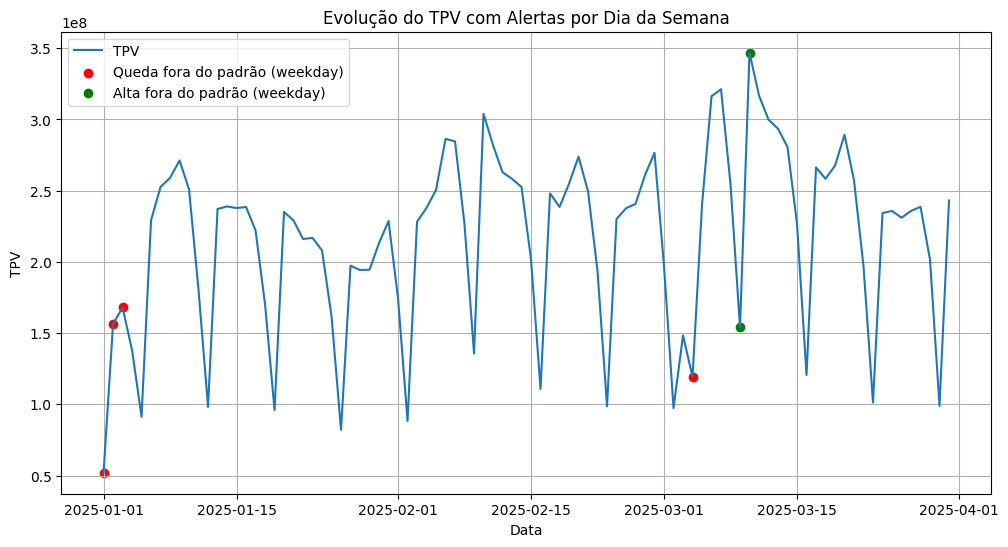

In [ ]:
# 0=segunda, 6=domingo
daily_kpis['weekday'] = daily_kpis['transaction_date'].dt.day_name()

# Média e desvio padrão do TPV por dia da semana
weekday_stats = daily_kpis.groupby('weekday')['TPV'].agg(['mean','std']).reset_index()
print(weekday_stats)

# Juntar estatísticas ao dataset
daily_kpis = daily_kpis.merge(weekday_stats, on='weekday', how='left', suffixes=('', '_weekday'))

# Criar alerta por dia da semana
daily_kpis['alerta_weekday'] = daily_kpis.apply(
    lambda x: 'queda' if x['TPV'] < x['mean'] - 2*x['std'] else (
              'alta' if x['TPV'] > x['mean'] + 2*x['std'] else 'ok'),
    axis=1
)

# Gerar gráfico
plt.figure(figsize=(12,6))
plt.plot(daily_kpis['transaction_date'], daily_kpis['TPV'], label="TPV")

queda = daily_kpis[daily_kpis['alerta_weekday']=="queda"]
alta = daily_kpis[daily_kpis['alerta_weekday']=="alta"]

plt.scatter(queda['transaction_date'], queda['TPV'], color="red", label="Queda fora do padrão (weekday)")
plt.scatter(alta['transaction_date'], alta['TPV'], color="green", label="Alta fora do padrão (weekday)")

plt.title("Evolução do TPV com Alertas por Dia da Semana")
plt.xlabel("Data")
plt.ylabel("TPV")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Caminho da pasta onde vamos salvar
output_dir = "streamlit/data"

# Criar se não existir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Salvar o arquivo de saída
daily_kpis.to_csv(os.path.join(output_dir, "kpis_gold.csv"), index=False)
print("Arquivo salvo em:", os.path.join(output_dir, "kpis_gold.csv"))

Arquivo salvo em: data\kpis_gold.csv
